# XGBoost Model build with Sagemaker inbuit container 

In [1]:
%matplotlib inline

# Load the data into a dataframe
import pandas as pd
import os

source_data_dir = 'data/raw'
clean_data_dir = 'data/train-test'

diabetes_df = pd.read_csv(os.path.join(source_data_dir, 'diabetes.csv'))

In [2]:
# separate features from labels
labels = diabetes_df.Outcome
data = diabetes_df.drop(columns = ['Outcome'])

In [3]:
#Define Min/Max 0-1 scaling of features
from sklearn.preprocessing import MinMaxScaler
cols = data.columns
scaler = MinMaxScaler()
#data = pd.DataFrame(scaler.fit_transform(X=data, y=None), columns=cols)

In [4]:
from sklearn.model_selection import train_test_split
random_state = 27

# split into train, valtest splits, putting 80% of data into training
X_train, X_valtest, y_train, y_valtest = train_test_split(data, labels, 
                                                          random_state = random_state,
                                                          test_size = .2)

# split remaining 20% of data in valtest equally so 10% validation / 10% testing
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,
                                                random_state = random_state,
                                                test_size = .5)
# Feature Scaling on X_Train to avoid leakage of data
sc = MinMaxScaler(feature_range = (0, 1))
#sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# print sizes to make sure we got what we expected
print("Training data shape: {} Training label shape: {}".format(X_train.shape, y_train.shape))
print("Validation data shape: {} Validation label shape: {}".format(X_val.shape, y_val.shape))
print("Testing data shape: {} Testing label shape: {}".format(X_test.shape, y_test.shape))

Training data shape: (614, 8) Training label shape: (614,)
Validation data shape: (77, 8) Validation label shape: (77,)
Testing data shape: (77, 8) Testing label shape: (77,)


In [5]:
#data_dir = 'data/processed'  # with manual pre-processed data accuracy score drops 
#it is effiecient to use auto robust preprocessing feature of XGBoost container
data_dir = 'data/splitted'
# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

# Upload data to AWS - S3 buket

In [7]:
# copy data to s3
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

# set prefix, a descriptive name for a directory  
prefix = 'capstone'

# upload all data to S3
input_data = sagemaker_session.upload_data(path= data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-2-750494204460/capstone


# Build XGBoost Model

In [8]:
# build xgBoost estimator
# configure estimator and construct the image name for the training container.
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=2, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [9]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

# Tune model with Hyperparameter tuner 

In [10]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 10, # The total number of models to train
                                               max_parallel_jobs = 5, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [11]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.

train_file_path = os.path.join(input_data, 'train.csv')
s3_input_train = sagemaker.s3_input(s3_data=train_file_path, content_type='csv')

val_file_path = os.path.join(input_data, 'validation.csv')
s3_input_val = sagemaker.s3_input(s3_data=val_file_path, content_type='csv')

#xgb.fit({'train': s3_input_train, 'validation': s3_input_val}) # Accuracy score is around 0.70
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_val})
xgb_hyperparameter_tuner.wait()

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


...............................................................................................................................................................!


In [12]:

%%time
#xgb_best_model = sagemaker.estimator.Estimator.attach(xgb.best_training_job())
# deploy model for testing
#predictor = xgb.deploy(initial_instance_count=1,
                                  #instance_type = 'ml.t2.medium')

xgb_best_model = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())
# deploy model for testing
predictor = xgb_best_model.deploy(initial_instance_count=1,
                                  instance_type = 'ml.t2.medium')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-14 20:07:49 Starting - Preparing the instances for training
2020-08-14 20:07:49 Downloading - Downloading input data
2020-08-14 20:07:49 Training - Training image download completed. Training in progress.
2020-08-14 20:07:49 Uploading - Uploading generated training model
2020-08-14 20:07:49 Completed - Training job completed

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Arguments: train
[2020-08-14:20:05:29:INFO] Running distributed xgboost training.
[2020-08-14:20:05:30:INFO] Number of hosts: 2, master IP address: 10.0.128.209, host IP address: 10.0.130.122.
[2020-08-14:20:05:30:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-ip-10-0-130-122.us-east-2.compute.internal.out
Arguments: train
[2020-08-14:20:05:29:INFO] Running distributed xgboost training.
[2020-08-14:20:05:30:INFO] Number of hosts: 2, master IP address: 10.0.128.209, host IP address: 10.0.128.209.
[2020-08-14:20:05:30:INFO] Finished Yarn configuration files setup.

starting namenode, logging to /opt/amazon/hadoop/logs/hadoop--namenode-ip-10-0-128-209.us-east-2.compute.internal.out
starting nodemanager, logging to /opt/amazon/hadoop/logs/yarn--nodemanager-ip-10-0-130-122.us-east-2.compute.internal.out
[2020-08-14:20:05:35:INFO] File size need to be processed in the node: 0.05mb. Available memory size in the node: 8225

In [13]:
xgb_best_model.hyperparameters()

{'_tuning_objective_metric': 'validation:auc',
 'early_stopping_rounds': '10',
 'eta': '0.43249326039846847',
 'gamma': '8.68055098585796',
 'max_depth': '9',
 'min_child_weight': '6',
 'num_round': '500',
 'objective': 'binary:logistic',
 'subsample': '0.5019892046937876'}

In [15]:
from sagemaker.predictor import csv_serializer
import numpy as np
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

y_preds = predictor.predict(X_test.values).decode('utf-8')

#y_test_preds = predictor.predict(X_test.values).decode('utf-8')
#y_valid_preds = predictor.predict(X_val.values).decode('utf-8')
#y_train_preds = predictor.predict(X_train.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
y_preds = np.fromstring(y_preds, sep=',')

# make sure the right number of labels are returned
assert len(y_preds)==len(y_test), 'Unexpected number of predictions.'
print('prediction completed.')

prediction completed.


# Evaluation and Validation of XGBoost Model

In [16]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

y_preds_ints = [round(num) for num in y_preds.squeeze()]

print(classification_report(y_test, y_preds_ints, labels = [0,1]))
print("ROC_AUC_Score: {}".format(roc_auc_score(y_test, y_preds)))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_preds_ints)))
#print("log loss: {}".format(accuracy_score(y_test, y_preds_ints)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        55
           1       0.57      0.55      0.56        22

    accuracy                           0.75        77
   macro avg       0.70      0.69      0.69        77
weighted avg       0.75      0.75      0.75        77

ROC_AUC_Score: 0.8301652892561983
Accuracy Score: 0.7532467532467533


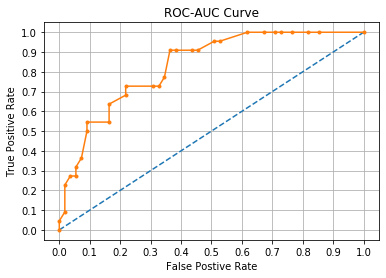

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

plt.figure()
plt.plot([0,1],[0,1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker = '.')
plt.title("ROC-AUC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Postive Rate")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid(True)

# show the plot
plt.show()


In [18]:

# clean up and summarize
predictor.delete_endpoint()